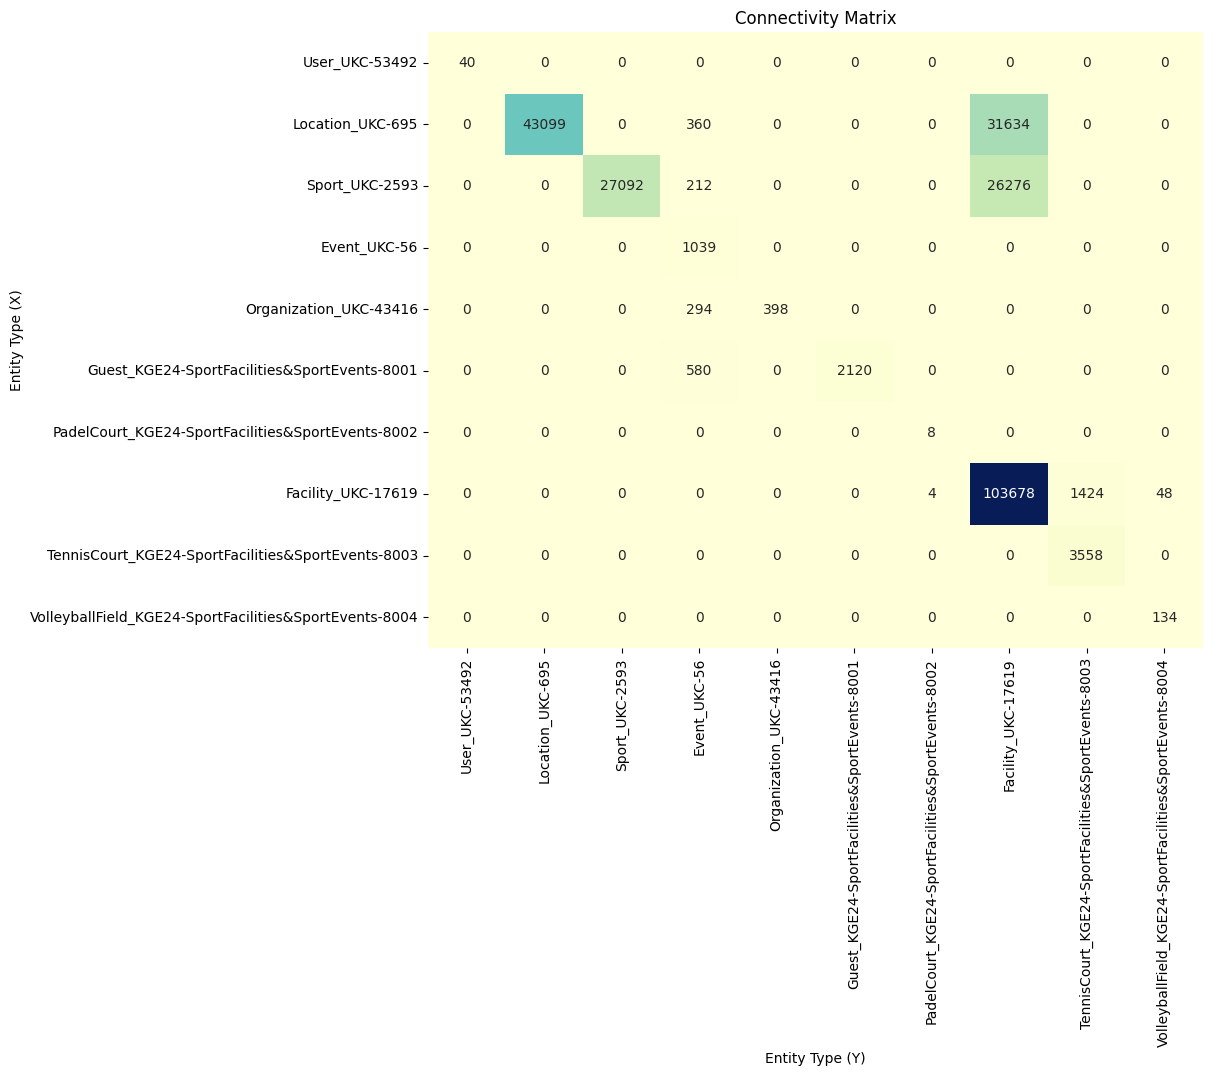

Entity Type: User_UKC-53492, Row Sum: 40, OP(X): 1, DP(X): 6
Entity Type: Location_UKC-695, Row Sum: 75093, OP(X): 3, DP(X): 4
Entity Type: Sport_UKC-2593, Row Sum: 53580, OP(X): 4, DP(X): 3
Entity Type: Event_UKC-56, Row Sum: 1039, OP(X): 1, DP(X): 5
Entity Type: Organization_UKC-43416, Row Sum: 692, OP(X): 3, DP(X): 3
Entity Type: Guest_KGE24-SportFacilities&SportEvents-8001, Row Sum: 2700, OP(X): 3, DP(X): 4
Entity Type: PadelCourt_KGE24-SportFacilities&SportEvents-8002, Row Sum: 8, OP(X): 1, DP(X): 2
Entity Type: Facility_UKC-17619, Row Sum: 105154, OP(X): 2, DP(X): 7
Entity Type: TennisCourt_KGE24-SportFacilities&SportEvents-8003, Row Sum: 3558, OP(X): 1, DP(X): 5
Entity Type: VolleyballField_KGE24-SportFacilities&SportEvents-8004, Row Sum: 134, OP(X): 1, DP(X): 4
Entity Connectivity for the whole KG: 96912.66666666666
Property Connectivity for the whole KG: 36242.79285714286


In [50]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure the GraphDB SPARQL endpoint
endpoint_url = "http://localhost:7200/repositories/sports"
sparql = SPARQLWrapper(endpoint_url)

# Retrieve relevant entity types
sparql.setQuery("""
SELECT DISTINCT ?etype
WHERE {
    ?s a ?etype .
    FILTER(STRSTARTS(STR(?etype), "http://knowdive.disi.unitn.it/etype#"))
}
""")
sparql.setReturnFormat(JSON)
etype_results = sparql.query().convert()
entity_types = [r['etype']['value'].split("#")[-1] for r in etype_results['results']['bindings']]  # Remove namespace

# Fetch data properties (X = Y)
data_properties = {}
for etype in entity_types:
    sparql.setQuery(f"""
    SELECT (COUNT(?dataValue) AS ?dataProperties)
    WHERE {{
        ?s a <http://knowdive.disi.unitn.it/etype#{etype}> ;
           ?dataProperty ?dataValue .
        FILTER(isLiteral(?dataValue))
    }}
    """)
    sparql.setReturnFormat(JSON)
    result = sparql.query().convert()
    data_properties[etype] = int(result['results']['bindings'][0]['dataProperties']['value'])

# Fetch object properties (X ≠ Y)
sparql.setQuery("""
SELECT ?domainEType ?rangeEType (COUNT(*) AS ?objectProperties)
WHERE {
    ?s a ?domainEType ;
       ?objectProperty ?o .
    ?o a ?rangeEType .
    FILTER(STRSTARTS(STR(?domainEType), "http://knowdive.disi.unitn.it/etype#"))
    FILTER(STRSTARTS(STR(?rangeEType), "http://knowdive.disi.unitn.it/etype#"))
    FILTER (?domainEType != ?rangeEType)
}
GROUP BY ?domainEType ?rangeEType
ORDER BY DESC(?objectProperties)
""")
sparql.setReturnFormat(JSON)
connection_results = sparql.query().convert()

# Create a DataFrame for object properties
connectivity_df = pd.DataFrame(0, index=entity_types, columns=entity_types)
for row in connection_results['results']['bindings']:
    domain = row['domainEType']['value'].split("#")[-1]
    range_ = row['rangeEType']['value'].split("#")[-1]
    count = int(row['objectProperties']['value'])
    connectivity_df.loc[domain, range_] = count

# Add data properties (X = Y) to the diagonal
for etype in entity_types:
    connectivity_df.loc[etype, etype] = data_properties.get(etype, 0)

# Visualize the connectivity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(connectivity_df, annot=True, fmt="d", cmap="YlGnBu", xticklabels=entity_types, yticklabels=entity_types, cbar=False)
plt.title("Connectivity Matrix")
plt.xlabel("Entity Type (Y)")
plt.ylabel("Entity Type (X)")
plt.show()

# Fetch Object Properties (OP(X)) for each entity type
object_properties_counts = {}
for etype in entity_types:
    sparql.setQuery(f"""
    SELECT (COUNT(DISTINCT ?p) AS ?numObjectProperties)
    WHERE {{
        ?s a <http://knowdive.disi.unitn.it/etype#{etype}> ;
           ?p ?o .
        FILTER(!isLiteral(?o))  # Ensure the value is not a literal (object property)
    }}
    """)
    sparql.setReturnFormat(JSON)
    result = sparql.query().convert()
    # OP(X): Count of distinct object properties
    object_properties_counts[etype] = int(result['results']['bindings'][0]['numObjectProperties']['value'])

# Fetch Data Properties (DP(X)) for each entity type
data_properties_counts = {}
for etype in entity_types:
    sparql.setQuery(f"""
    SELECT (COUNT(DISTINCT ?p) AS ?numDataProperties)
    WHERE {{
        ?s a <http://knowdive.disi.unitn.it/etype#{etype}> ;
           ?p ?o .
        FILTER(isLiteral(?o))  # Ensure the value is a literal (data property)
    }}
    """)
    sparql.setReturnFormat(JSON)
    result = sparql.query().convert()
    data_properties_counts[etype] = int(result['results']['bindings'][0]['numDataProperties']['value'])



# Compute Entity Connectivity (EC) and Property Connectivity (PC) for each entity type
ec_values = {}
property_connectivity = {}

for etype in entity_types:
    # Row sum: Sum of all connections from etype to others, including itself
    row_sum = connectivity_df.loc[etype, :].sum()
    # Object properties (OP(X)) for the entity type
    op_x = object_properties_counts.get(etype, 0)
    # Data properties (DP(X)) for the entity type
    dp_count = data_properties_counts.get(etype, 0)
    
    # Calculate EC(X)
    ec_values[etype] = row_sum / op_x if op_x != 0 else 0
    
    # Calculate PC(X)
    property_connectivity[etype] = connectivity_df.loc[etype, etype] / dp_count if dp_count != 0 else 0

    print(f"Entity Type: {etype}, Row Sum: {row_sum}, OP(X): {op_x}, DP(X): {dp_count}")



# Compute EC(KG) and PC(KG)
ec_kg = sum(ec_values.values())
print(f"Entity Connectivity for the whole KG: {ec_kg}")

pc_kg = sum(property_connectivity.values())
print("Property Connectivity for the whole KG:", pc_kg)

